In [22]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
plt.rc('figure', figsize=(6,4))
plt.rc('font', size=11)
plt.style.use('dark_background')
# plt.rc('figure',facecolor=(0,0,0,0)) # Set transparent background
%config InlineBackend.figure_format='retina'

In [2]:
import quflow as qf

# Generate random vorticity and plot it

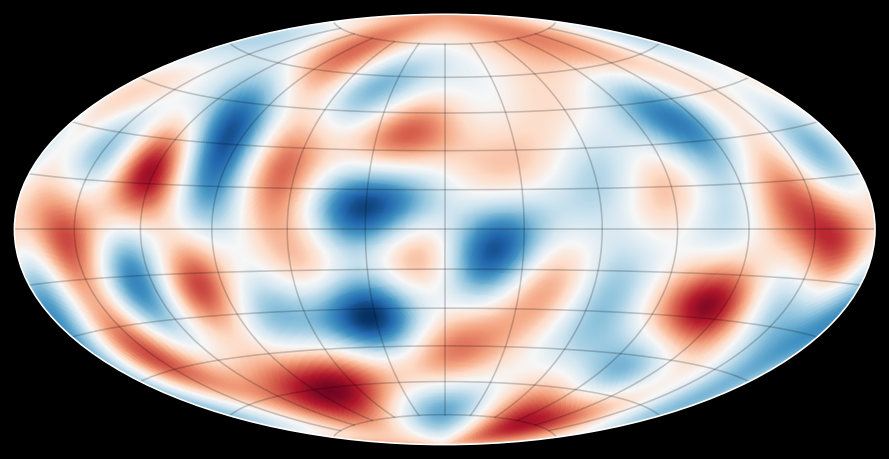

In [28]:
lmax = 10  # How many spherical harmonics (SH) coefficients to include
np.random.seed(42)  # For reproducability
omega0 = np.random.randn(lmax**2)  # Array with SH coefficients
qf.plot2(omega0,projection='hammer', N=512)  # Plot command

# Simulation of Euler's equations on the sphere

In vorticity formulation, Euler's equations are
$$\dot\omega = \{\psi,\omega\} $$
where $\omega$ is the vorticity function and $\psi$ is the stream function (related to $\omega$ via Poisson's equation). The quantized Euler equations are similar
$$\dot W = [P,W] $$
but here the vorticity function is replaced by the vorticity matrix $W \in \mathfrak{su}(N)$ and a corresponding stream matrix $P\in\mathfrak{su}(N)$.

### ISOMP method using fixed point iterations
The method is
$$
    W_n = (I- \frac{h}{2}P_{n+1/2})W_{n+1/2}(I + \frac{h}{2} P_{n+1/2})
$$
$$
    W_{n+1} = (I + \frac{h}{2}P_{n+1/2})W_{n+1/2}(I - \frac{h}{2} P_{n+1/2})
$$
From the first equation we get
$$
    W_{n+1/2} - W_n =  \frac{h}{2}( P_{n+1/2}W_{n+1/2}- W_{n+1/2}P_{n+1/2} ) + \frac{h^2}{4} P_{n+1/2}W_{n+1/2}P_{n+1/2}.
$$
If we set $\delta W = W_{n+1/2} - W_n$ this equation leads to a fixed point iteration
$$
    W_{n+1/2}^{(k)} = W_n + \delta W^{(k)}
$$
$$
    \delta W^{(k+1)} = \frac{h}{2}( P_{n+1/2}^{(k)}W_{n+1/2}^{(k)}- W_{n+1/2}^{(k)}P_{n+1/2}^{(k)} ) + \frac{h^2}{4} P_{n+1/2}^{(k)}W_{n+1/2}^{(k)}P_{n+1/2}^{(k)}.
$$
Once converged, we have for $W_{n+1}$ that
$$
    W_{n+1} = W_n + \delta W^{(k+1)} + \frac{h}{2}( P_{n+1/2}^{(k)}W_{n+1/2}^{(k)}- W_{n+1/2}^{(k)}P_{n+1/2}^{(k)} ) - \frac{h^2}{4} P_{n+1/2}^{(k)}W_{n+1/2}^{(k)}P_{n+1/2}^{(k)},
$$
which is equivalent to
$$
    W_{n+1} = W_n + h( P_{n+1/2}^{(k)}W_{n+1/2}^{(k)}- W_{n+1/2}^{(k)}P_{n+1/2}^{(k)} ).
$$


## Create initial conditions

In [4]:
N = 128  # Size of matrices
W0 = qf.shr2mat(omega0, N=N)  # Convert SH coefficients to matrix
P0 = qf.solve_poisson(W0)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


## Run simulation

In [29]:
# filename = "my_sim_N_{}_isonewton.hdf5".format(str(N))
filename = "my_sim_N_{}_isofix.hdf5".format(str(N))
# filename = "my_sim_N_{}_isonewton.hdf5".format(str(N))
# filename = "my_sim_N_{}_heun.hdf5".format(str(N))
time = 3.0 # in second
inner_time = 0.5 # in seconds
qstepsize = 0.2 # in qtime

In [32]:
# Run this if you want to remove the existing hdf5 file
%rm $filename

rm: my_sim_N_128_isofix.hdf5: No such file or directory


In [33]:
dt = qf.qtime2seconds(qstepsize, N)
print("The physical stepsize is {:.3e} seconds.".format(dt))
print("{} steps per output, in total {} steps.".format(round(inner_time/dt), round(time/dt)))

The physical stepsize is 9.792e-04 seconds.
511 steps per output, in total 3064 steps.


In [37]:

# Callback data object
mysim = qf.QuData(filename)

# Save initial conditions if file does not exist already, otherwise load from last step
try:
    f = h5py.File(filename, "r")
except IOError or KeyError:
    W = W0.copy()
    mysim(W, 0.0)
else:
    W = qf.shr2mat(f['state'][-1,:], N=N)
    assert W.shape[0] == N, "Looks like the saved data use N = {} whereas you specified N = {}.".format(W.shape[0], N)
    f.close()

# Select solver
if "isonewton" in filename:
    solver = qf.isomp
elif "isofix" in filename:
    solver = qf.isomp_fixedpoint_skewherm
elif "heun" in filename:
    solver = qf.heun
elif "rk4" in filename:
    solver = qf.rk4
else:
    solver = qf.rk4

# Run simulation

qf.solve(W, qstepsize=qstepsize, time=time, inner_time=inner_time, callback=mysim,
         method=solver, method_kwargs={"verbatim":True, "maxit":7, "tol":1e-8})

# Flush cache data
mysim.flush()

  0%|          | 0/3064 [00:00<?, ? steps/s]

Average number of iterations per step: 5.00
Average number of iterations per step: 5.00
Average number of iterations per step: 5.00
Average number of iterations per step: 5.00
Average number of iterations per step: 5.00
Average number of iterations per step: 5.00


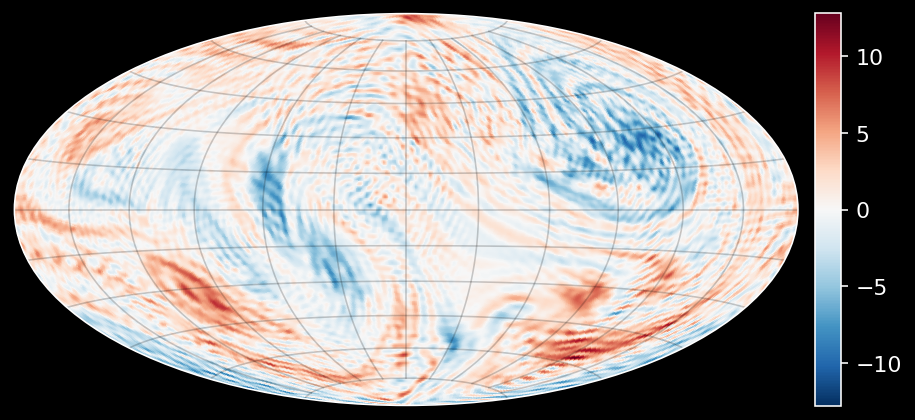

In [36]:
# Plot last state
with h5py.File(filename, 'r') as data:
    omega = data['state'][-1]
    qf.plot2(omega, projection='hammer', N=512, colorbar=True)

38


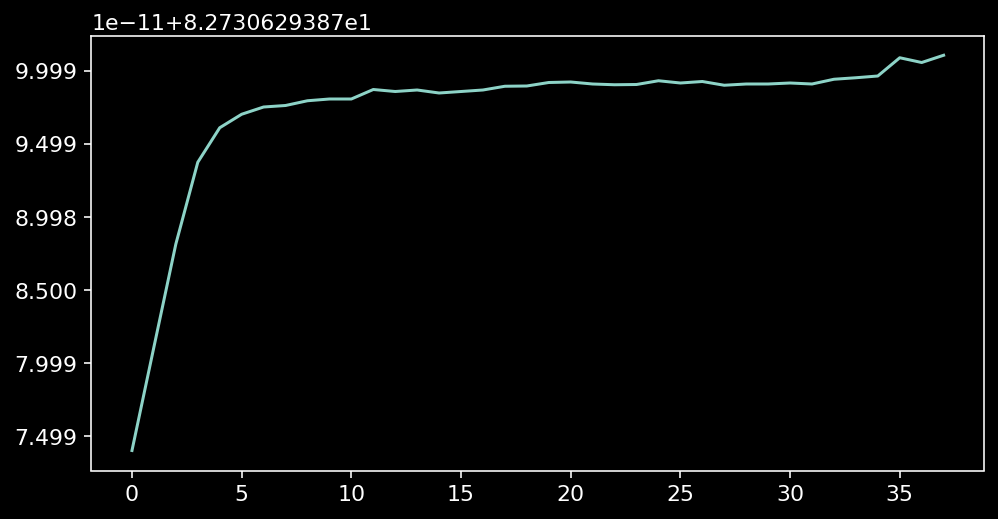

In [19]:
with h5py.File(filename, 'r') as data:
    casimir = []
    print(data['state'].shape[0])
    for k in range(data['state'].shape[0]):
        omega = data['state'][k]
        casimir += [np.linalg.norm(omega)**2]
    casimir = np.asarray(casimir)
    plt.figure(figsize=(8,4))
    plt.plot(casimir)

## Animate the results

In [21]:
with h5py.File(filename, 'r') as data:
    anim = qf.create_animation2(filename.replace(".hdf5",".mp4"), data['state'], projection='mollweide', N=256)
anim

  0%|          | 0/38 [00:00<?, ? frames/s]

## Compute canonical decomposition

In [17]:
[Ws,Wr]=qf.scale_decomposition(W)
P = qf.solve_poisson(W)

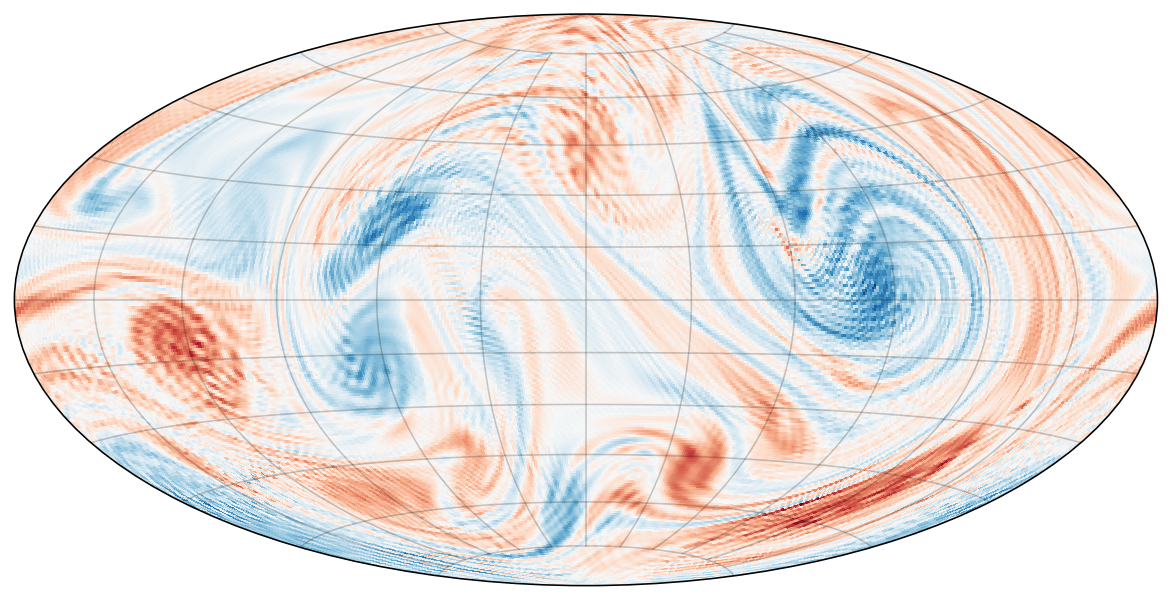

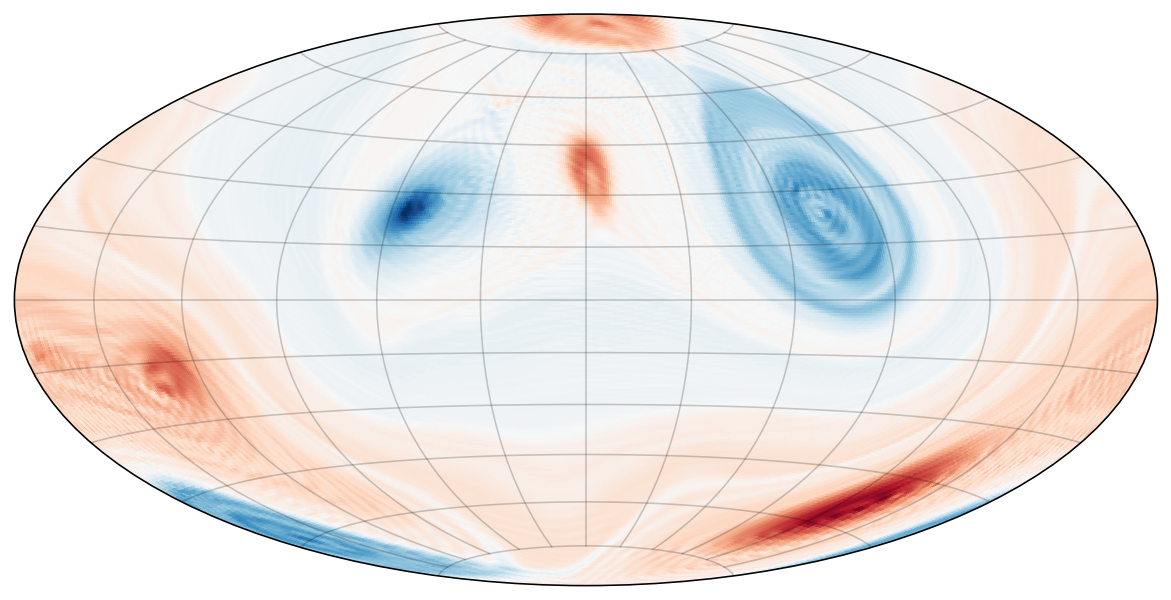

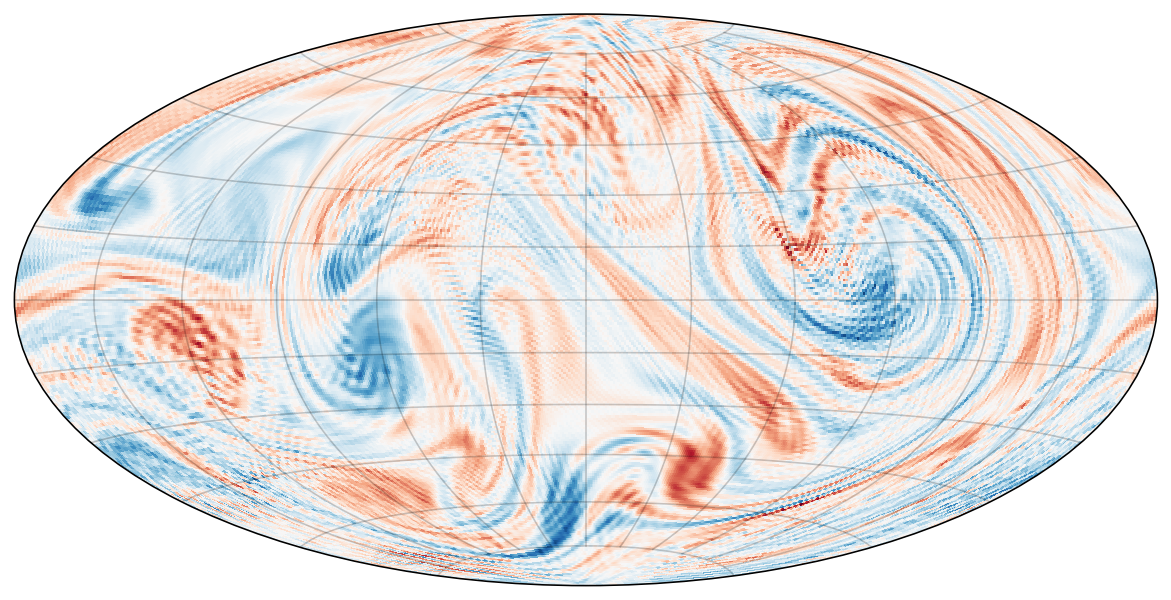

In [22]:
for Ww in [W, Ws, Wr]:
    qf.plot2(Ww, projection='hammer')

## Run on cluster

In [8]:
import quflow.cluster as cluster
# from quflow import commutator

In [14]:
epsilon = 0.01

def forcing(P, W):
    Ws, Wr = qf.scale_decomposition(W, P)
    return -epsilon*Wr

force_code = In[len(In)-1]

In [15]:
# Start longer simulation on cluster
cluster.solve(filename, qstepsize=qstepsize, time=time, inner_time=inner_time, 
              method_kwargs={'forcing':forcing}, prerun=force_code,
              upload=True, submit=True)

/Users/moklas/Documents/Coding/quflow/quflow/cluster.py:438: UserWarning: Could not establish jobstatus.
  warnings.warn("Could not establish jobstatus.")


#### CREATING RUN FILES ####
########### DONE ###########

#### UPLOADING FILES TO SERVER ####
> rsync -auv my_sim_N_128.hdf5 my_sim_N_128_run.py my_sim_N_128_submit.sh my_sim_N_128_args.pickle my_sim_N_128_cluster.pickle vera2:simulations/my_sim_N_128
building file list ... done
created directory simulations/my_sim_N_128
my_sim_N_128.hdf5
my_sim_N_128_args.pickle
my_sim_N_128_cluster.pickle
my_sim_N_128_run.py
my_sim_N_128_submit.sh

sent 7302271 bytes  received 130 bytes  14604802.00 bytes/sec
total size is 7300991  speedup is 1.00
> rsync -auv --exclude __pycache__ --exclude .DS_Store /Users/moklas/Documents/Coding/quflow/quflow vera2:simulations/my_sim_N_128
building file list ... done
quflow/
quflow/__init__.py
quflow/cluster.py
quflow/dynamics.py
quflow/graphics.py
quflow/io.py
quflow/quantization.py
quflow/splittingflow.py
quflow/transforms.py
quflow/utils.py
quflow/laplacian/
quflow/laplacian/__init__.py
quflow/laplacian/direct.py
quflow/laplacian/sparse.py
quflow/laplacian/tri

In [27]:
# Check status
cluster.status(filename)

 Animation: 100%|##########| 79/79 [00:10<00:00,  7.24 frames/s] (jobstatus: not running)


In [28]:
cluster.jobstatus()

JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)


In [29]:
cluster.retrieve(filename, onlyanim=True)

> rsync -auv vera2:'simulations/my_sim_N_128/my_sim_N_128.mp4' .
receiving file list ... done
my_sim_N_128.mp4

sent 8744 bytes  received 1227898 bytes  824428.00 bytes/sec
total size is 1227463  speedup is 0.99
